In [2]:
import os
import pandas as pd

# Function to read the specified file and extract the highest elevation
def extract_highest_elevation(file_path):
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    highest_elevation = data[0].max()  # Extracting from the first column
    return highest_elevation

# Initialize an empty list to store the data
data = []

# Root folder containing all scenarios
root_folder = r'C:\Users\elmoe\Desktop\simulasi3'

# List of base folder names and their corresponding scenario ranges
folders = [
    ('east_sc', range(1, 21)), ('east_sc', range(161, 181)),
    ('north_sc', range(21, 41)), ('north_sc', range(181, 201)),
    ('northeast_sc', range(41, 61)), ('northeast_sc', range(201, 221)),
    ('northwest_sc', range(61, 81)), ('northwest_sc', range(221, 241)),
    ('south_sc', range(81, 101)), ('south_sc', range(241, 261)),
    ('southeast_sc', range(101, 121)), ('southeast_sc', range(261, 281)),
    ('southwest_sc', range(121, 141)), ('southwest_sc', range(281, 301)),
    ('west_sc', range(141, 161)), ('west_sc', range(301, 321))
]

# Iterate over each base folder and scenario range
for base_folder, scenario_range in folders:
    for i in scenario_range:
        scenario_folder = f"{base_folder}{i}"
        scenario_path = os.path.join(root_folder, scenario_folder)
        input_files = [os.path.join(scenario_path, f'ts_record000{j}.dat') for j in range(1, 7)]
        output_file = os.path.join(scenario_path, 'ts_record0009.dat')
        
        # Check if all input files exist
        if all(os.path.exists(file) for file in input_files) and os.path.exists(output_file):
            input_elevations = [extract_highest_elevation(file) for file in input_files]
            output_elevation = extract_highest_elevation(output_file)
            data.append(input_elevations + [output_elevation])
        else:
            print(f"File(s) missing in scenario: {scenario_folder}")

# Convert to DataFrame
columns = [f'HighestElevation_ts_record000{j}' for j in range(1, 7)] + ['HighestElevation_ts_record0009']
df = pd.DataFrame(data, columns=columns)

# Save the compiled data to a CSV file
df.to_csv('compiled_tsunami_data_multivariate_ciwandan_as_target.csv', index=False)

print("Data compilation complete.")

Data compilation complete.


Random Forest Regressor RMSE: 0.11259892228642447
Gradient Boosting Regressor RMSE: 0.12001655291430653
Epoch 1/100
7/7 [==============================] - 1s 31ms/step - loss: 0.2788 - val_loss: 0.1242
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.1049 - val_loss: 0.0849
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0809 - val_loss: 0.0796
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0540 - val_loss: 0.0771
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0443 - val_loss: 0.0750
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0371 - val_loss: 0.0751
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0309 - val_loss: 0.0746
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0275 - val_loss: 0.0631
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0243 - val_loss: 0.0541
Epoch 10/100
7/7 [====

C:\Users\elmoe\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


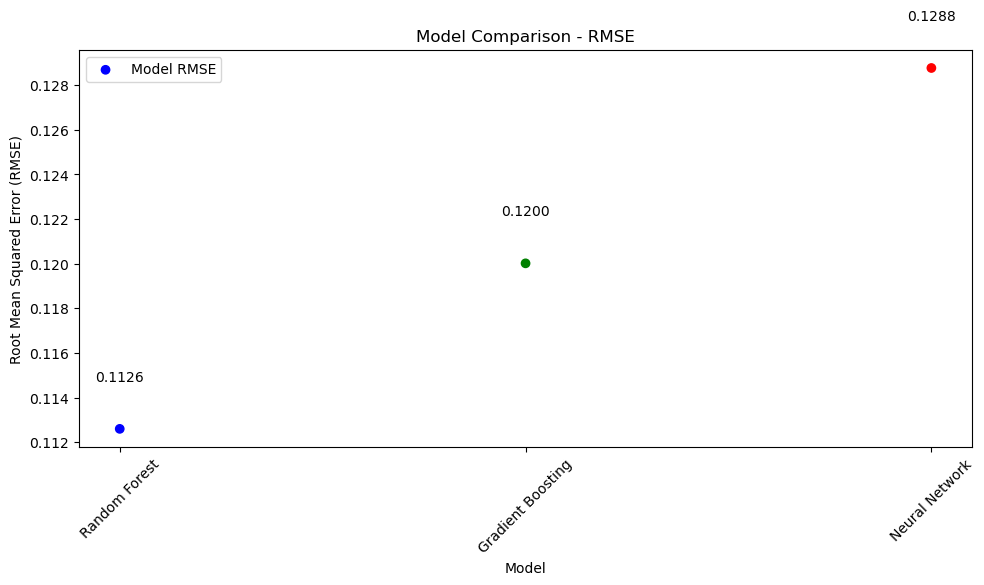

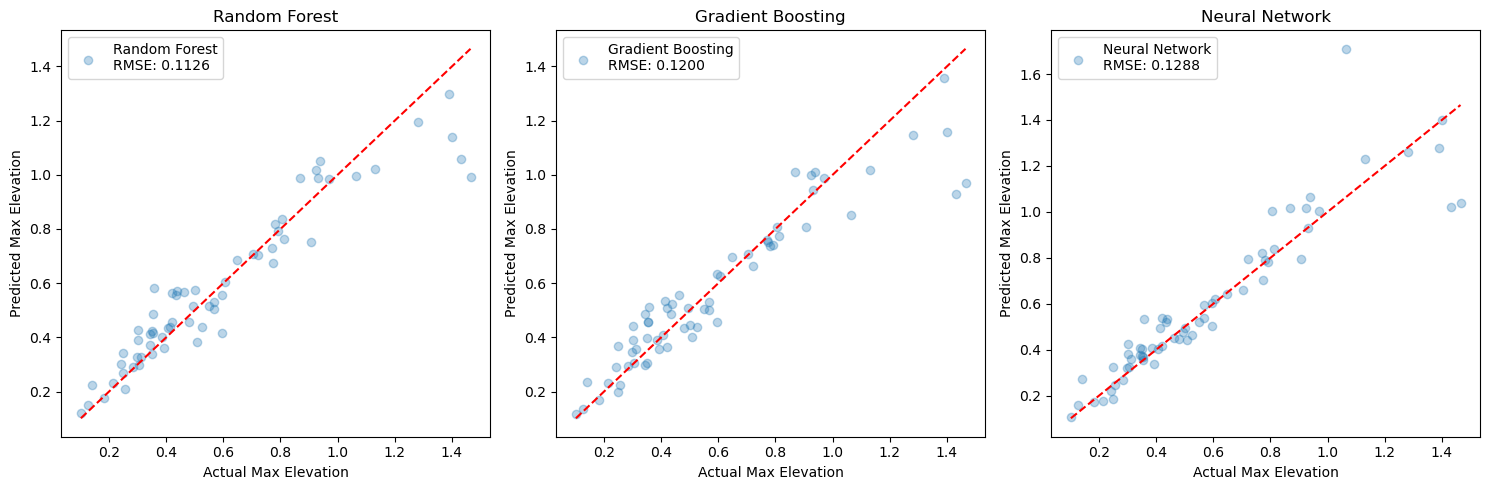

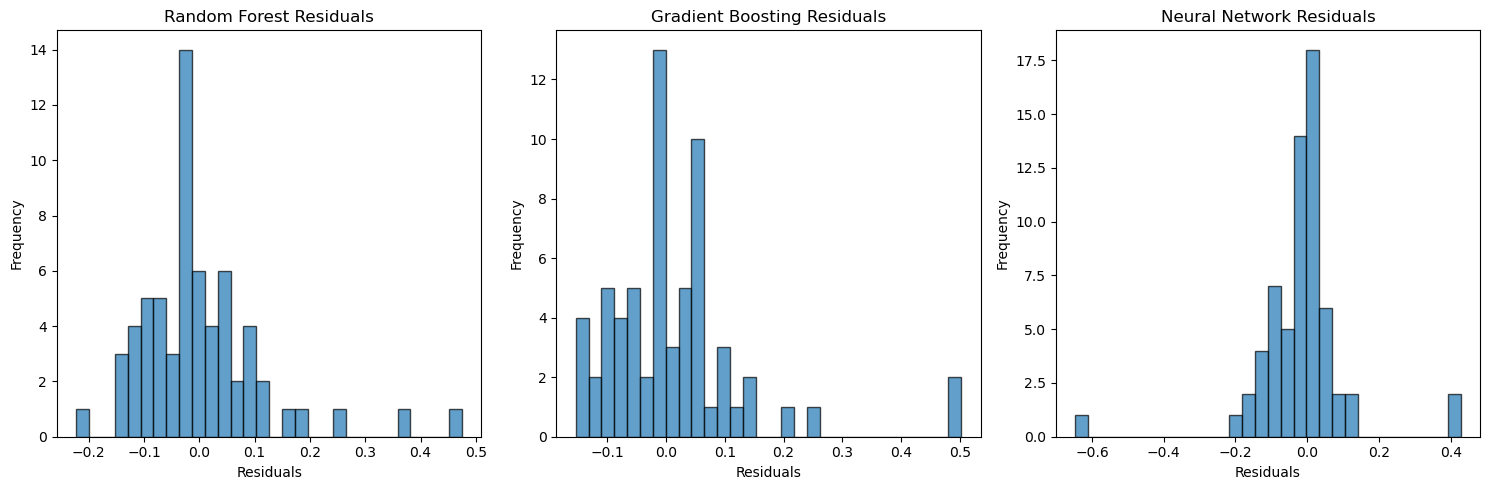

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import joblib
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the data (assuming 'compiled_tsunami_data_multivariate_marina_jambu_as_target.csv' is available)
df = pd.read_csv('compiled_tsunami_data_multivariate_ciwandan_as_target.csv')

# Prepare features (X) and target (y)
X = df[[f'HighestElevation_ts_record000{j}' for j in range(1, 7)]]
y = df['HighestElevation_ts_record0009']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
print(f'Random Forest Regressor RMSE: {rmse_rf}')
joblib.dump(rf, 'tsunami_forecasting_rf_model.pkl')

# Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
rmse_gbr = mse_gbr ** 0.5
print(f'Gradient Boosting Regressor RMSE: {rmse_gbr}')
joblib.dump(gbr, 'tsunami_forecasting_gbr_model.pkl')

# Scale the data for Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
nn_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)
y_pred_nn = nn_model.predict(X_test_scaled).flatten()
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = mse_nn ** 0.5
print(f'Neural Network RMSE: {rmse_nn}')
nn_model.save('tsunami_forecasting_nn_model.h5')
joblib.dump(scaler, 'scaler.pkl')

# Specify the directory to save figures
save_dir = 'figures/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Visualize the comparison - RMSE
rmse_values = [rmse_rf, rmse_gbr, rmse_nn]
model_names = ['Random Forest', 'Gradient Boosting', 'Neural Network']

plt.figure(figsize=(10, 6))
plt.scatter(model_names, rmse_values, color=['blue', 'green', 'red'], marker='o', label='Model RMSE')
plt.xlabel('Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Model Comparison - RMSE')
for i, rmse in enumerate(rmse_values):
    plt.text(model_names[i], rmse + 0.002, f'{rmse:.4f}', ha='center', va='bottom')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(save_dir + 'model_comparison_rmse.png')
plt.show()

# Plot actual vs predicted values for each model and save each figure
plt.figure(figsize=(15, 5))

# Random Forest
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.3, label=f'Random Forest\nRMSE: {rmse_rf:.4f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Max Elevation')
plt.ylabel('Predicted Max Elevation')
plt.title('Random Forest')
plt.legend()
plt.savefig(save_dir + 'random_forest_scatter.png')

# Gradient Boosting
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_gbr, alpha=0.3, label=f'Gradient Boosting\nRMSE: {rmse_gbr:.4f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Max Elevation')
plt.ylabel('Predicted Max Elevation')
plt.title('Gradient Boosting')
plt.legend()
plt.savefig(save_dir + 'gradient_boosting_scatter.png')

# Neural Network
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_nn, alpha=0.3, label=f'Neural Network\nRMSE: {rmse_nn:.4f}')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Max Elevation')
plt.ylabel('Predicted Max Elevation')
plt.title('Neural Network')
plt.legend()
plt.savefig(save_dir + 'neural_network_scatter.png')

plt.tight_layout()
plt.show()

# Plot residuals for each model and save each figure
plt.figure(figsize=(15, 5))

# Random Forest
plt.subplot(1, 3, 1)
residuals_rf = y_test - y_pred_rf
plt.hist(residuals_rf, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Random Forest Residuals')
plt.savefig(save_dir + 'random_forest_residuals.png')

# Gradient Boosting
plt.subplot(1, 3, 2)
residuals_gbr = y_test - y_pred_gbr
plt.hist(residuals_gbr, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Gradient Boosting Residuals')
plt.savefig(save_dir + 'gradient_boosting_residuals.png')

# Neural Network
plt.subplot(1, 3, 3)
residuals_nn = y_test - y_pred_nn
plt.hist(residuals_nn, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Neural Network Residuals')
plt.savefig(save_dir + 'neural_network_residuals.png')

plt.tight_layout()
plt.show()